In [1]:
import math
import itertools
import pytz
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pypsa#for time.sleep

import TriPhaseController as tpc

from datetime import datetime, timedelta
from IPython.display import clear_output
from IPython.display import display
from pathlib import Path
%matplotlib inline

#  Optimization

The optimum_prise function:

The goal of the EMS system is optimizing the energy usage in micro grid and minimizing the
impact of the micro grid into an external grid -> Assume that the energy deliver back (export) to
the grid has no pay back, the electricity imports from grid are expensive and there are differences
between day and night tariff. The micro grid has battery and internal storage. The network is
shown in figure 1.
The EMS needs future info from the solar prediction model, load demand prediction model and
the current state of charge (SOC) of the battery to make planning for battery usage.

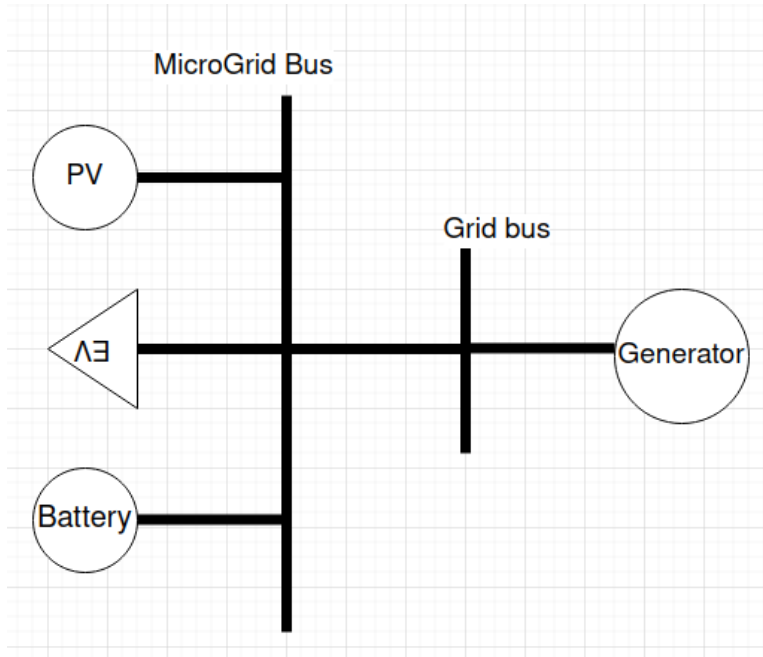


In [3]:
def Optimum_prise(SOC, P_pv_pu_Test, bev_usage):
    
    """Calculate the I_SP of the battery in the next 24 hours.

    Function which use the battery to minimizing the impact of the micro grid into an external grid 
    -> Assume that the energy deliver back (export) to the grid has no pay back, 
    the electricity imports from grid are expensive and there are differences between day and night tariff

    Input: 
         SOC: Current state of chare of the battery in %
         P_pv_pu_Test: Solar prediction in Kw
         bev_usage: EV charing prediction in Kw



    Return:
        network: The define network
        Bat_SOC: The predicted SOC of micro grid battery. 
        I_sp   : Current setpoint to use triphase system to charge and dischare the battery.   
        bev_usage: Predicted EV profile
    """
    
    StartTimeObj = datetime.now()
    EndTimeObj = StartTimeObj + timedelta(hours=47)
    
    StartTimeStr = StartTimeObj.strftime("%Y-%m-%d %H:%M")
    StartDayStr = StartTimeObj.strftime("%Y-%m-%d")
    
    EndTimeStr = EndTimeObj.strftime("%Y-%m-%d %H:%M")
    EndDayStr = EndTimeObj.strftime("%Y-%m-%d")
    
    #------------------------------------------------------------------------------------------------------
    # Will be removed in future
    #------------------------------------------------------------------------------------------------------

    
    # use 24 hour period for consideration
    index = pd.date_range(StartTimeStr,EndTimeStr, freq="H")
    #index = pd.date_range("2021-01-01 00:00","2021-01-02 23:00", freq="H")


    # consumption pattern of BEV
    bev_usage = pd.Series([0.]*7 + [0]*2 + [4.]*4 + [4.]*4 + [0.]*2 + [0.]*5 +
                          [0.]*7 + [5]*2 + [9.]*4 + [2.]*4 + [0.]*2 + [0.]*5, index)


    P_pv_pu_Test = pd.Series([0.]*7 + [0.2,0.4,0.6,0.75,0.85,0.9,0.85,0.75,0.6,0.4,0.2,0.1] + [0.]*5
                             +[0.]*7 + [0.2,0.4,0.3,0.2,0.5,0.1,0.4,0.4,0.6,0.4,0.2,0.1] + [0.]*5, index)
    P_pv_pu_Test = P_pv_pu_Test/3.5

    # day tariff
    day_p_max_pu = pd.Series(0, index=index)
    day_p_max_pu[StartDayStr + " 07:00":StartDayStr + " 22:00"] = 1.
    day_p_max_pu[EndDayStr   + " 07:00":EndDayStr   + " 22:00"] = 1.
    #day_p_max_pu["2021-01-01 07:00":"2021-01-01 22:00"] = 1.
    #day_p_max_pu["2021-01-02 07:00":"2021-01-02 22:00"] = 1.
    
    # night tariff
    night_p_max_pu = pd.Series(0, index=index)
    night_p_max_pu[StartDayStr + " 00:00":StartDayStr + " 07:00"] = 1.
    night_p_max_pu[EndDayStr   + " 00:00":EndDayStr   + " 07:00"] = 1.
    #night_p_max_pu["2021-01-01 00:00":"2021-01-01 07:00"] = 1.
    #night_p_max_pu["2021-01-02 00:00":"2021-01-02 07:00"] = 1.

    #------------------------------------------------------------------------------------------------------

    
    network = pypsa.Network()
    network.set_snapshots(index)

    network.add("Bus",
                "House Connection",
                 carrier="AC")

    #network.add("Bus",
    #            "Grid_day",
    #            carrier="AC")

    network.add("Bus",
                "Grid_night",
                carrier="AC")

    #network.add("Generator",
    #            "PV panel",
    #            bus="House Connection",
    #            p_nom_extendable=True, #The size of the PV will be determined by the OPF
    #            p_max_pu=P_pv_pu,
    #            marginal_cost=0.019) # [Euro/KWh]

    network.add("Generator",
                "PV panel",
                bus="House Connection",
                p_nom = 15,
                p_max_pu=P_pv_pu_Test,
                p_min_pu=P_pv_pu_Test,
                marginal_cost=0.019) # [Euro/KWh]

    network.add("Load",
                "House Loads",
                bus="House Connection",
                p_set=bev_usage)

    network.add("StorageUnit",
                "Home_Battery",
                bus="House Connection",
                p_nom=5,
                p_min_pu = -1,
                state_of_charge_initial=SOC*5/100,
                cyclic_state_of_charge =False,
                efficiency_store = 0.9,
                efficiency_dispatch =0.9,
                marginal_cost=20)



    # marginal cost for discharge
    network.add("StorageUnit",
                "Grid_day",
                bus="House Connection",
                p_nom=1000000,
                p_min_pu = -1,
                state_of_charge_initial=1000000/2,
                cyclic_state_of_charge =False,
                efficiency_store = 0.5,
                efficiency_dispatch =0.5,
                marginal_cost=100)

    # marginal cost for discharge
    network.add("StorageUnit",
                "Grid_night",
                bus="Grid_night",
                p_nom=1000000,
                p_min_pu = -1,
                state_of_charge_initial=1000000/2,
                cyclic_state_of_charge =False,
                efficiency_store = 0.5,
                efficiency_dispatch =0.5,
                marginal_cost=10)


    network.add("Link",
                "Gird_to_house_night",
                bus0="Grid_night",
                bus1="House Connection",
                p_nom=100,  #super-charger with 120 kW (0.12 MVA) ->> check how possile?
                p_max_pu=night_p_max_pu,
                efficiency=0.9)

    # e_nom : Nominal energy capacity. (MWH)
    # e_cyclick : Switch: if True, 
    # then e_initial is ignored and the initial energy 
    # is set to the final energy for the group of snapshots in the OPF.
    network.lopf(network.snapshots)
    Bat_SOC= (network.storage_units_t.state_of_charge['Home_Battery']/network.storage_units.p_nom_opt['Home_Battery'])*100
    kw_to_current_sp = 1000/(230*3) # 3phase
    I_sp = network.storage_units_t.p['Home_Battery']*kw_to_current_sp
    
    return network, Bat_SOC, I_sp, bev_usage

In [4]:
network, Bat_SOC, I_sp, bev_usage = Optimum_prise(40,1,2)

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 4270.39606349276
  Upper bound: 4270.39606349276
  Number of objectives: 1
  Number of constraints: 481
  Number of variables: 529
  Number of nonzeros: 1246
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05980086326599121
# ----------------------------------------------------------
#   Solution Information
# --------

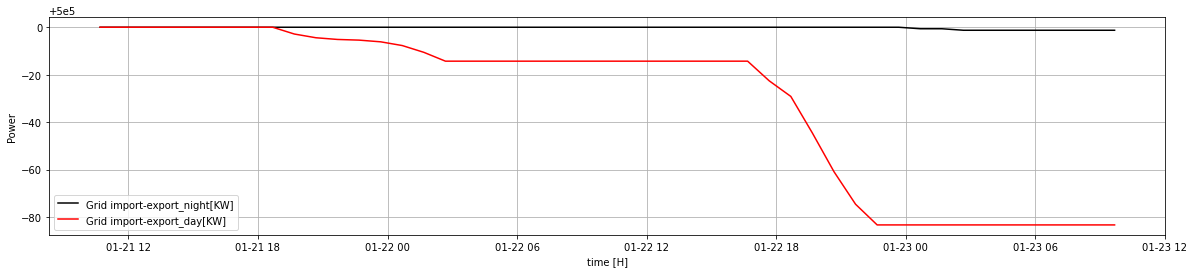

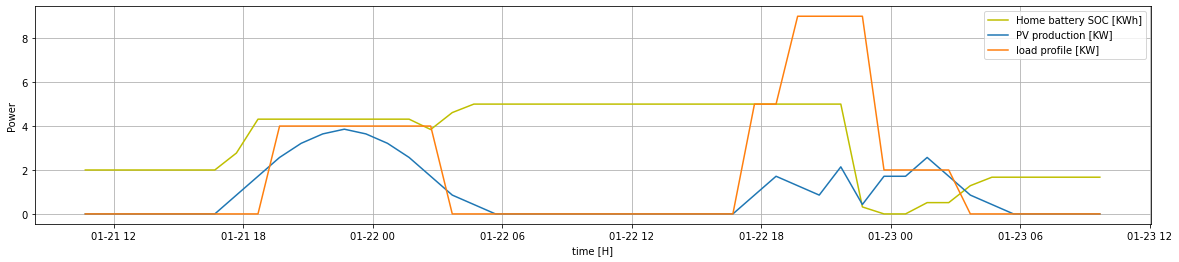

In [5]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(network.storage_units_t.state_of_charge['Grid_night'],'k',label='Grid import-export_night[KW]')
ax.plot(network.storage_units_t.state_of_charge['Grid_day'],'r',label='Grid import-export_day[KW]')
ax.set(xlabel='time [H]', ylabel='Power',title='')
ax.grid()
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(network.storage_units_t.state_of_charge['Home_Battery'],'y',label='Home battery SOC [KWh]')
ax.plot(network.generators_t['p']['PV panel'],label='PV production [KW]')
ax.plot(bev_usage,label='load profile [KW]')
ax.set(xlabel='time [H]', ylabel='Power',title='')

ax.grid()
plt.legend()
plt.show()


#plt.plot(network.storage_units_t['p']['Home_Battery'])
#plt.plot(network.storage_units_t['p']['Grid_Battery'])
#plt.plot(network.generators_t['p']['Grid import'],label='grid import')
#plt.plot(network.stores_t['p']['Grid'])
#plt.plot(network.stores_t['e']['Grid'])

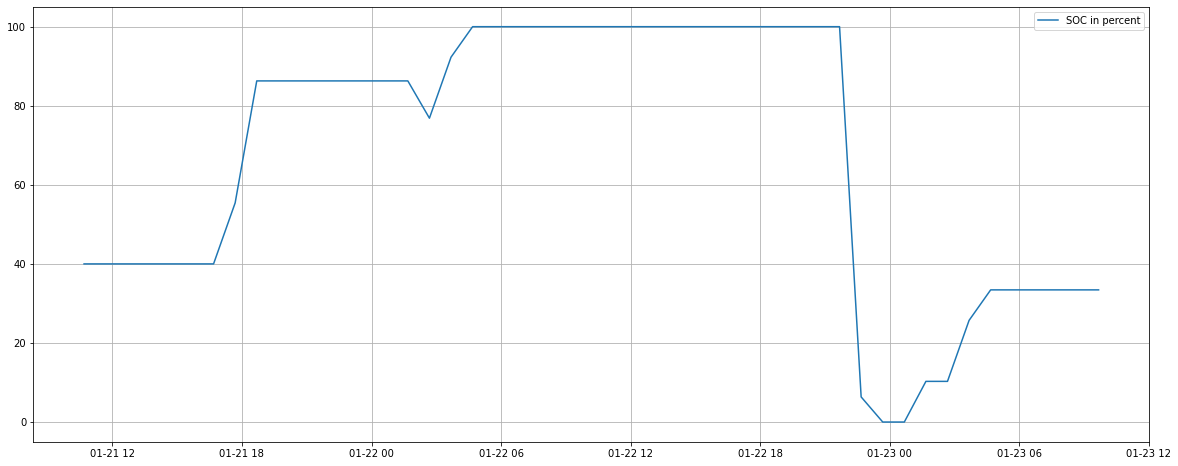

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(Bat_SOC,label='SOC in percent')
plt.grid()
plt.legend()
plt.show()

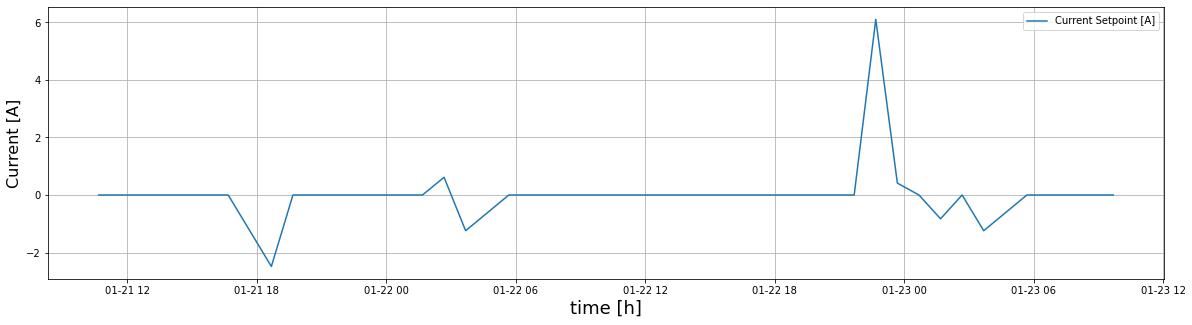

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(I_sp,label='Current Setpoint [A]')
plt.xlabel('time [h]', fontsize=18)
plt.ylabel('Current [A]', fontsize=16)
plt.grid()
plt.legend()
plt.show()

# Start the triphase controller

In [7]:
test_model = tpc.Controller()
test_model.set_advanced_callback(Optimum_prise)
test_model.set_demo_mode(False)

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.9p1)
INFO:paramiko.transport:Authentication (password) successful!
INFO:paramiko.transport.sftp:[chan 0] Opened sftp connection (server version 3)


In [51]:
test_model.start_model()

The parameter: COMMAND_CENTER/External_param is set to 1.0.
The parameter: syst/precharge_P30_1 is set to 1.0.
The parameter: af/enable is set to 1.0.
The parameter: syst/precharge_P30_1 is set to 0.0.


In [53]:
test_model.m.stop()

The model: PM15A30I60F06_afAC3_vsAC3_csDC1 has stopped.


In [16]:
import pylab as pl

In [52]:
# ADD PREDICTION HERE #####################################################################
# data of prediction is time series
prediction = [{'EV': 12e3, 'PV': 10e3}, {'EV': 13e3, 'PV': 15e3}, {'EV': 14e3, 'PV': 20e3}, 
            {'EV': 13e3, 'PV': 10e3}, {'EV': 10e3, 'PV': 5e3}]
###########################################################################################

while True:
    
    if not test_model.is_demo():
        network, Bat_SOC, I_sp, bev_usage = test_model.power_control(prediction)
        
        i_out = test_model.m.capture_data(['cs/i_out'], samples = 1, decimation = 1)
        [i_sp] = list(i_out.data.values())
        
        arr = test_model.find_SOC_past()
        
        print('SOC:',arr)
        print('Current setpoint: ' + str(i_sp.item()))
        #pl.figure(figsize=(20, 8))
        #pl.clf()
        #plt.plot(arr,label='SOC in percent')
        #plt.grid()
        #plt.legend()
        #plt.show()
        
        #plt.clf()
        #plt.plot(Bat_SOC,label='SOC prediction in percent')
        #plt.grid()
        #plt.legend()
        #plt.show()
        
        
        clear_output(wait=True)
        #display(pl.gcf())
        
        time.sleep(10)
        #pl.close()

KeyboardInterrupt: 

In [46]:
i_sp

array([[0.245178]])

In [47]:
i_out.data

OrderedDict([('cs/i_out', array([[0.245178]]))])

In [48]:
I_sp

snapshot
2022-01-14 14:16:00   -6.486599e-11
2022-01-14 15:16:00    0.000000e+00
2022-01-14 16:16:00    0.000000e+00
2022-01-14 17:16:00    0.000000e+00
2022-01-14 18:16:00    0.000000e+00
2022-01-14 19:16:00    0.000000e+00
2022-01-14 20:16:00    0.000000e+00
2022-01-14 21:16:00   -1.242236e+00
2022-01-14 22:16:00   -2.484472e+00
2022-01-14 23:16:00    0.000000e+00
2022-01-15 00:16:00    0.000000e+00
2022-01-15 01:16:00    0.000000e+00
2022-01-15 02:16:00    0.000000e+00
2022-01-15 03:16:00    0.000000e+00
2022-01-15 04:16:00    0.000000e+00
2022-01-15 05:16:00    0.000000e+00
2022-01-15 06:16:00    0.000000e+00
2022-01-15 07:16:00   -1.242236e+00
2022-01-15 08:16:00   -6.211180e-01
2022-01-15 09:16:00    0.000000e+00
2022-01-15 10:16:00    0.000000e+00
2022-01-15 11:16:00    0.000000e+00
2022-01-15 12:16:00    0.000000e+00
2022-01-15 13:16:00    0.000000e+00
2022-01-15 14:16:00    0.000000e+00
2022-01-15 15:16:00    0.000000e+00
2022-01-15 16:16:00    0.000000e+00
2022-01-15 17:16:00